<a href="https://colab.research.google.com/github/christianhbye/bayesian-analysis/blob/main/homeworks/HW2_288.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

## <em>Intro to Data Analysis, Dimensionality Reduction, and Clustering</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

### Imports

In [79]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Mounting Google Drive locally
Mount your Google Drive on your runtime using an authorization code.

Note: When using the 'Mount Drive' button in the file browser, no authentication codes are necessary for notebooks that have only been edited by the current user.

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***

#### Problem 1 - Fitting Gaussian Contours to a 2D Data

Gaussian distribution function plays a central role in statistics and is the most ubiquitous distribution in physics. It often provides a good approximation to the true probability density function (pdf) even in cases where its application is not strictly correct. <br><br>
In this problem, suppose that you have measured 1000 pairs of values $(x_1, y_1), ... , (x_{1000}, y_{1000})$ of two variables $x, y$. You saved these measurements to a .dat file ("Problem1_data.dat"). Plot their 1-dimensional pdf's and determine how well Gaussian pdf can approximate them. Compute the mean, variance, median, mode, 68% and 95% confidence intervals, and correlation coefficient.

<span style="color:blue"><i> 1. Plot 1-dimensional pdf for $x$, i.e. plot a normalized histogram. Make a reasonable choice for bin size - say 40 bins? </i></span> <br>

In [81]:
# Load a given 2D data
data = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW2/Problem1_data.dat")
x = data[:,0]
y = data[:,1]

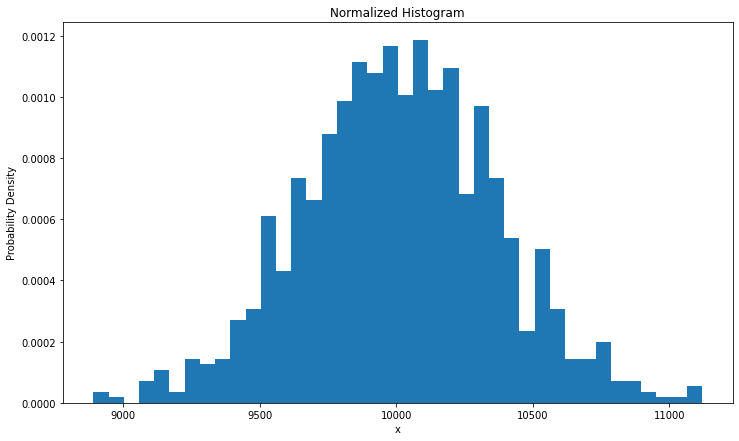

In [82]:
# Hint - https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html
plt.figure(figsize=(12, 7))
bins = 40
xhist, xbins = plt.hist(x, bins=bins, density=True)[:2]
plt.ylabel("Probability Density")
plt.xlabel("x")
plt.title("Normalized Histogram")
plt.show()

<span style="color:blue"> <i> 2. Calculate the mean, variance, and median of $x$. First, do it without using any in-built functions. Then, check your answers using in-built functions from numpy. </i></span>

In [83]:
def mean(data):
  data = np.array(data)
  N = len(data)
  return data.sum() / N

def variance(data):
  data = np.array(data)
  m = mean(data)
  s = (data - m) **2  # spread squared
  return mean(s)

def median(data):
  N = len(data)
  sorted = np.sort(data)
  if N%2 == 1:  # odd number of data points
    return sorted[N//2]  # the middle point
  else:  # even number of points: take avg of the two midpoints
    m1 = sorted[N//2 - 1]
    m2 = sorted[N//2]
    return mean([m1, m2])

In [84]:
print(f"Mean of x = {mean(x):.3e}")
print(f"Variance of x = {variance(x):.3e}")
print(f"Median of x = {median(x):.3e}")
print("\n----------------------\n")
print("Numpy functions:")
print(f"Mean of x = {np.mean(x):.3e}")
print(f"Variance of x = {np.var(x):.3e}")
print(f"Median of x = {np.median(x):.3e}")

# assert that the outputs are identical
assert mean(x) == np.mean(x)
assert variance(x) == np.var(x)
assert median(x) == np.median(x)

Mean of x = 1.001e+04
Variance of x = 1.254e+05
Median of x = 1.001e+04

----------------------

Numpy functions:
Mean of x = 1.001e+04
Variance of x = 1.254e+05
Median of x = 1.001e+04


<span style="color:blue"> <i> 3. Smoothly interpolate the discrete probability density from Part 1. Then, find the mode and symmetric 68%, 95% confidence intervals. (Suggestion - Read https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html and https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html)</i></span><br><br>


In [85]:
from scipy.interpolate import UnivariateSpline

# xhist defined above contains the y-values of the histogram for x
# xbins are the edges of the bins. We compute the centers by adding half widths to the left edges
xbinwidth = xbins[1] - xbins[0]  # width of the bins
xcenters = xbins[:-1] + 1/2 * xbinwidth # centers of bins
xvals = np.linspace(xbins[0], xbins[-1], num=250)  # the values of x
spline = UnivariateSpline(xcenters, xhist, s=2e-7)
x_smooth = spline(xvals)  # evaluiate the spline at smooth x

x_mode_ix = x_smooth.argmax()  # the bin corresponding to the mode
x_mode = xvals[x_mode_ix]  # mode of x
print(f"Mode of x: {x_mode:.3e}")

Mode of x: 1.003e+04


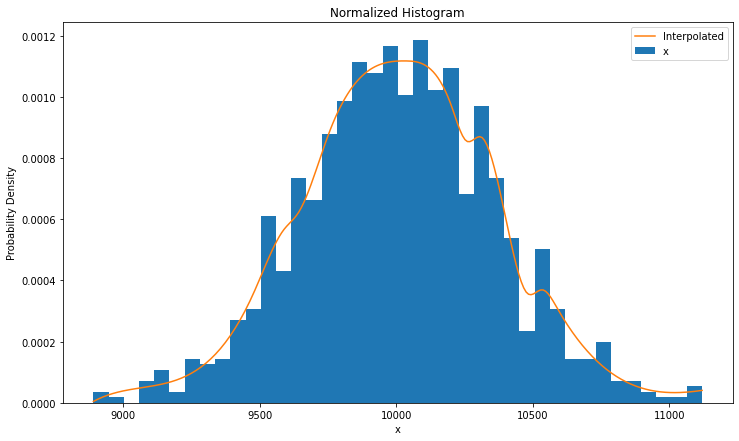

In [86]:
plt.figure(figsize=(12, 7))
plt.hist(x, bins=bins, density=True, label="x")
plt.plot(xvals, x_smooth, label="Interpolated")
plt.legend()
plt.ylabel("Probability Density")
plt.xlabel("x")
plt.title("Normalized Histogram")
plt.show()

In [87]:
"""
confidence intervals:
we integrate the pdf to get the cdf, then we use the mode we found above as the center and find the interval around it
that amounts to 68% and 95%
"""

# integrate:
x_cdf = x_smooth.cumsum() * (xvals[1] - xvals[0])  # cumulative sum gives us the integral at each bin


# write down the forward problem and try to invert it
def confidence(cdf, mode_ix, nbins):
  """
  Compute the confidence that a random variable is within a width of ``nbins'' from
  the mode_ix (the bin corresponding to the mode) given its cdf
  """
  cdf_max = cdf[mode_ix + nbins]
  cdf_min = cdf[mode_ix - nbins]
  return cdf_max - cdf_min

# number of bins to check that the CI might be
nbins_ci = np.arange(len(xvals)-x_mode_ix)

# confidence intervals as function of nbins
x_ci = confidence(x_cdf, x_mode_ix, nbins_ci)

# 68 % CI
x68_nbins = np.argmin(np.abs(x_ci - 0.68))
x68_min = x_mode_ix - x68_nbins
x68_max = x_mode_ix + x68_nbins

x_68ci = (xvals[x68_min], xvals[x68_max])
print(f"68% CI for x: {x_68ci}")

# 95 % CI
x95_nbins = np.argmin(np.abs(x_ci - 0.95))
x95_min = x_mode_ix - x95_nbins
x95_max = x_mode_ix + x95_nbins

x_95ci = (xvals[x95_min], xvals[x95_max])
print(f"95% CI for x: {x_95ci}")

68% CI for x: (9678.930839332274, 10377.037347107405)
95% CI for x: (9329.877585444707, 10726.090600994972)


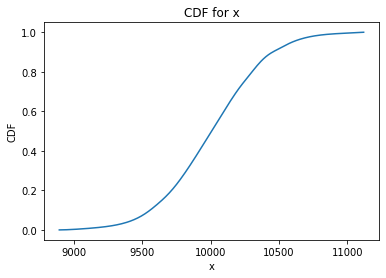

In [88]:
plt.figure()
plt.plot(xvals, x_cdf)
plt.title("CDF for x")
plt.xlabel("x")
plt.ylabel("CDF")
plt.show()

Assuming that the distribution is Gaussian, 68% and 95% confidence interval corresponds to $\mu \pm 1\sigma$ and $\mu \pm 2\sigma$.  </i></span>

In [89]:
# assuming Gaussian distribution

# compute the standard deviation:
xstd = np.sqrt(variance(x))

print("x")
print("---")
xmin68, xmax68 = mean(x) - xstd, mean(x) + xstd
print(f"68% confidence: [{xmin68:.3e}, {xmax68:.3e}]")
xmin95, xmax95 = xmin68 - xstd, xmax68 + xstd
print(f"95% confidence: [{xmin95:.3e}, {xmax95:.3e}]")

x
---
68% confidence: [9.657e+03, 1.037e+04]
95% confidence: [9.303e+03, 1.072e+04]


We see that the confidence intervals of the Gaussian approximation do not differ much from the direct computation from CDF. Thus, the Gaussian distribution is a reasonable approximation for the PDF of x.

You should find that the Gaussian distribution is a reasonable approximation in this case.

<span style="color:blue"> <i> 4. Plot a Gaussian distribution with the mean and variance from Q2, on top of the probability density histogram from Q1. Make sure to label each plot. </i></span>

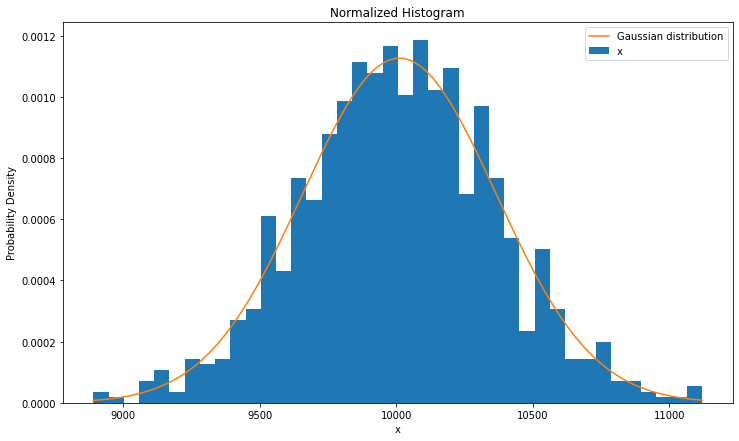

In [90]:
def gauss(x, mean, var):
  sigma = np.sqrt(var)
  z = (x - mean)/sigma
  amplitude = 1 / (np.sqrt(2 * np.pi) * sigma)
  return amplitude * np.exp(-1/2 * z**2)


plt.figure(figsize=(12, 7))
plt.hist(x, bins=bins, density=True, label="x")
plt.plot(xvals, gauss(xvals, mean(x), variance(x)), label="Gaussian distribution")
plt.ylabel("Probability Density")
plt.xlabel("x")
plt.title("Normalized Histogram")
plt.legend()
plt.show()


<span style="color:blue"> <i> 5. Repeat part 1-4 for $y$.  </i></span>

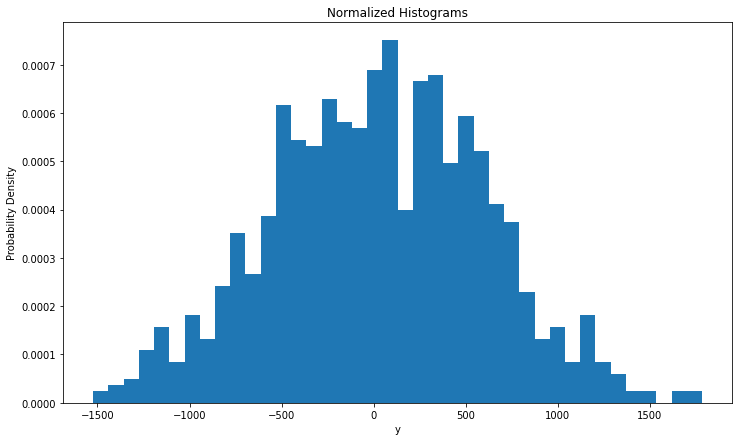

In [91]:
plt.figure(figsize=(12, 7))
yhist, ybins = plt.hist(y, bins=bins, density=True)[:2]
plt.ylabel("Probability Density")
plt.xlabel("y")
plt.title("Normalized Histograms")
plt.show()

In [92]:
print(f"Mean of y = {mean(y):.3e}")
print(f"Variance of y = {variance(y):.3e}")
print(f"Median of y = {median(y):.3e}")
print("\n----------------------\n")
print("Numpy functions:")
print(f"Mean of y = {np.mean(y):.3e}")
print(f"Variance of y = {np.var(y):.3e}")
print(f"Median of y = {np.median(y):.3e}")

# assert that the outputs are identical
assert mean(y) == np.mean(y)
assert variance(y) == np.var(y)
assert median(y) == np.median(y)

Mean of y = 2.583e+01
Variance of y = 3.390e+05
Median of y = 3.217e+01

----------------------

Numpy functions:
Mean of y = 2.583e+01
Variance of y = 3.390e+05
Median of y = 3.217e+01


In [93]:
ybinwidth = ybins[1] - ybins[0]
ycenters = ybins[:-1] + 1/2 * ybinwidth
yvals = np.linspace(ybins[0], ybins[-1], num=250)
yspline = UnivariateSpline(ycenters, yhist, s=2e-7)
y_smooth = yspline(yvals)

y_mode_ix = y_smooth.argmax()
y_mode = yvals[y_mode_ix]
print(f"Mode of y: {y_mode:.3e}")

Mode of y: 7.018e+01


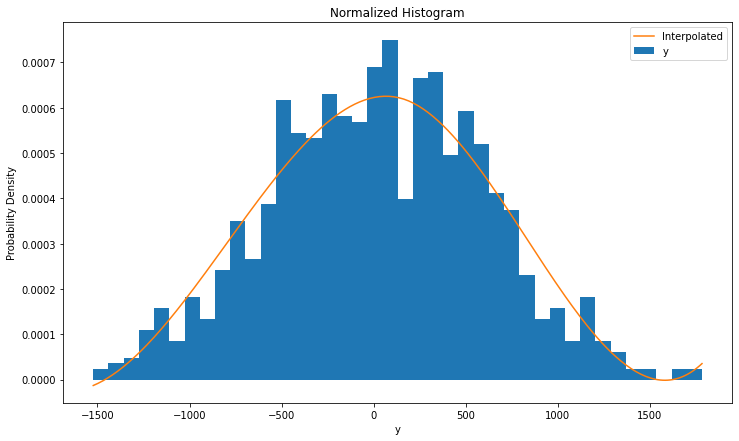

In [94]:
plt.figure(figsize=(12, 7))
plt.hist(y, bins=bins, density=True, label="y")
plt.plot(yvals, y_smooth, label="Interpolated")
plt.legend()
plt.ylabel("Probability Density")
plt.xlabel("y")
plt.title("Normalized Histogram")
plt.show()

In [95]:
y_cdf = y_smooth.cumsum() * (yvals[1] - yvals[0])

y_nbins_ci = np.arange(len(yvals)-y_mode_ix)

y_ci = confidence(y_cdf, y_mode_ix, y_nbins_ci)

# 68 % CI
y68_nbins = np.argmin(np.abs(y_ci - 0.68))
y68_min = y_mode_ix - y68_nbins
y68_max = y_mode_ix + y68_nbins

y_68ci = (yvals[y68_min], yvals[y68_max])
print(f"68% CI for y: {y_68ci}")

# 95 % CI
y95_nbins = np.argmin(np.abs(y_ci - 0.95))
y95_min = y_mode_ix - y95_nbins
y95_max = y_mode_ix + y95_nbins

y_95ci = (yvals[x95_min], yvals[x95_max])
print(f"95% CI for y: {y_95ci}")

68% CI for y: (-540.5468614028974, 680.9026429522025)
95% CI for y: (-872.4624875863485, 1198.6910197983864)


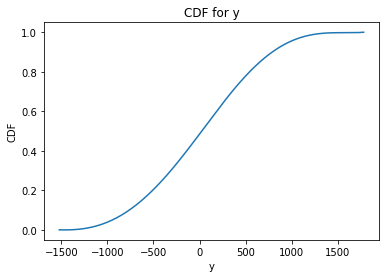

In [96]:
plt.figure()
plt.plot(yvals, y_cdf)
plt.title("CDF for y")
plt.xlabel("y")
plt.ylabel("CDF")
plt.show()

In [97]:
ystd = np.sqrt(variance(y))

print("y")
print("---")
ymin68, ymax68 = mean(y) - ystd, mean(y) + ystd
print(f"68% confidence: [{ymin68:.3e}, {ymax68:.3e}]")
ymin95, ymax95 = ymin68 - ystd, ymax68 + ystd
print(f"95% confidence: [{ymin95:.3e}, {ymax95:.3e}]")

y
---
68% confidence: [-5.564e+02, 6.081e+02]
95% confidence: [-1.139e+03, 1.190e+03]


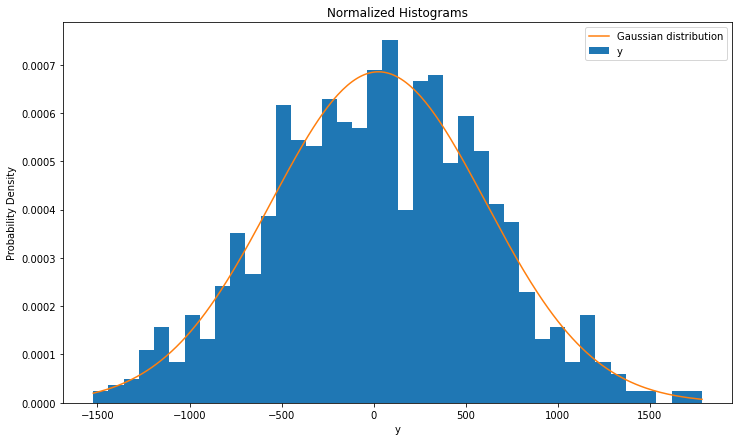

In [98]:
plt.figure(figsize=(12, 7))
plt.hist(y, bins=bins, density=True, label="y")
plt.plot(yvals, gauss(yvals, mean(y), variance(y)), label="Gaussian distribution")
plt.ylabel("Probability Density")
plt.xlabel("y")
plt.title("Normalized Histograms")
plt.legend()
plt.show()

<span style="color:blue"> <i> 6. First, compute the covariance ($C_{xy}$) of $x$ and $y$ as well as the correlation coefficient $\rho = \frac{C_{xy}}{\sigma_{x}\sigma_{y}}$. Print the results. Then, make a 2-d scatter plot of the dataset with few Gaussian contours (ellipses). </i></span>

In [99]:
def cov(x, y):
  sx = x - mean(x)  # spread of x
  sy = y - mean(y)  # spread of y
  return mean(sx*sy)  # expectation value of sx*sy

print(f"The covariance of x and y is {cov(x,y):.3g}.")

def corr_coeff(x, y):
  # the standard deviations are the sqrt of variances
  sigma_x = np.sqrt(cov(x, x))
  sigma_y = np.sqrt(cov(y, y))
  return cov(x, y) / (sigma_x * sigma_y)

print(f"The correlation coefficient of x and y is {corr_coeff(x,y):.3g}.")

The covariance of x and y is 1.66e+05.
The correlation coefficient of x and y is 0.807.


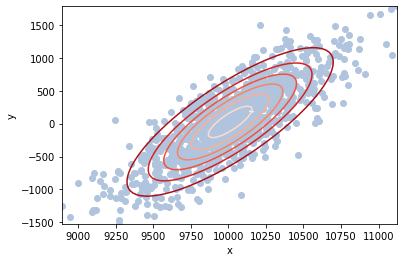

In [100]:
def gauss_xy(x, y, sigma_x, sigma_y, mean_x, mean_y, corr):
  """
  Bivariate Gaussian as function of x and y given standard deviations, means and
  correlation coefficient

  Taken from WolframAlpha: https://mathworld.wolfram.com/BivariateNormalDistribution.html
  """
  xz = (x - mean_x)/sigma_x
  yz = (y - mean_y)/sigma_y
  z = xz**2 + yz**2 - 2 * xz * yz * corr
  amp = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - corr**2))
  return amp * np.exp(-1/2 * z / (1 - corr**2)) 

# compute the 2d pdf from gridded x and y
xgrid = np.linspace(x.min(), x.max(), num=100)
ygrid = np.linspace(y.min(), y.max(), num=100)
X, Y = np.meshgrid(xgrid, ygrid)
prob2d = gauss_xy(X, Y, np.sqrt(variance(x)), np.sqrt(variance(y)), mean(x), mean(y), corr_coeff(x, y))



plt.figure()
plt.scatter(x, y, color="lightsteelblue")
plt.contour(X, Y, prob2d, cmap="Reds_r")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The above contour plot is a bird eye view of the 3-d mesh plot; these are ellipses of equal probability. The coloring represents the intensity. Yellow central ellipse is the region of highest probability; the peak of 2-d Gaussian distribution is at the center of this ellipse. As we move away from the peak, the probability lowers.

***

#### Problem 2 - Central Limit Theorem

Plot the binomial distribution $P(N_A, N)$ for different values of $N$ and plot the Gaussian with mean and variance for the binomial. Similarly, plot the Poisson distribution with the mean varying from 1 to 10. See if both binomial and Poisson approach Gaussian as the mean/$N$ increases.<br><br>
(Reference - Kardar p. 41) For the binomial distribution, consider a random variable with two outcomes $A$ and $B$ of relative probabilities $p_A$ and $p_B = 1 - p_A$. The probability that in $N$ trials the event $A$ occurs exactly $N_A$ times is given by the binomial distribution:
$$ p_N(N_A) = \binom{N}{N_A} p_A^{N_A}(1-p_A)^{N-N_A}. $$
<br>
<span style="color:blue"> <i> 1. Plot the binomial distribution $P(N_A, N)$ for $N = 5, 20, 40, 100, 300$. In the same figure, plot the Gaussian with mean and variance for the binomial and see how similar they get as you increase $N$. Let $p_A = 0.5$ and $0.1$. Make sure to label each plot.  </i></span>

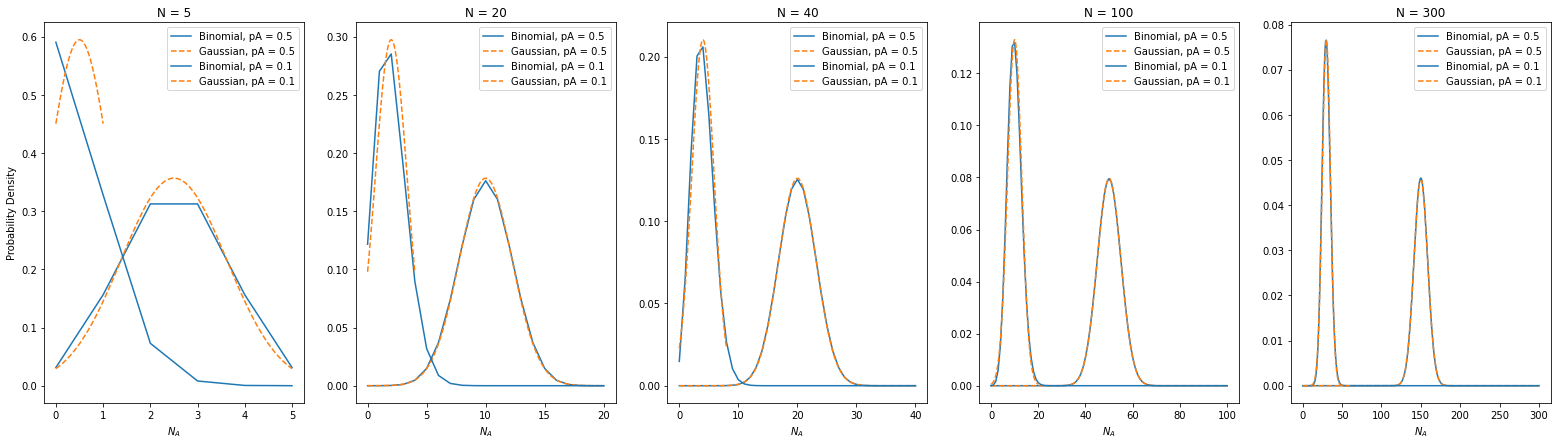

In [101]:
"""
We note that the mean of the binomial is N*pA and the variance is N*pA*(1-pA)
"""

from scipy.special import comb  # n choose k

def binomial(N_A, N, p_A):
  return comb(N, N_A) * p_A**N_A * (1-p_A)**(N-N_A)

N_vals = [5, 20, 40, 100, 300]
pA_vals = [0.5, 0.1]


fig, axs = plt.subplots(figsize=(27, 7), ncols=len(N_vals))
for i, N in enumerate(N_vals):
  plt.sca(axs.ravel()[i])
  NA = np.arange(N+1)
  for pA in pA_vals:
    b = binomial(NA, N, pA)
    plt.plot(NA, b, label=f"Binomial, pA = {pA}", color="C0")
    mean = N * pA
    variance = N * pA * (1-pA)
    smooth_NA = np.linspace(0, 2*mean, 100)
    g = gauss(smooth_NA, mean, variance)
    plt.plot(smooth_NA, g, label=f"Gaussian, pA = {pA}", color="C1", ls="--")
  plt.legend()
  plt.xlabel("$N_A$")
  if i == 0:
    plt.ylabel("Probability Density")
  plt.title(f"N = {N}")
plt.show()

In class, we find that the binomial distribution is approximately normal (with mean $Np_A$ and variance $Np_A(1-p_A)$) as $N \rightarrow \infty$, by the central limit theorem. The proof of this theorem can be carried out using Stirling's approximation:
$$ N! \approx N^N e^{-N}\sqrt{2\pi N} $$
<br>
<span style="color:blue"><i> 2. Plot the above Stirling's formula approximation (i.e. Compare $N!$ with Stirling's approximation. Compute the residual: (actual-estimate)/actual.) </i></span><br>
(Hint: $\Gamma(n+1) = n!$)


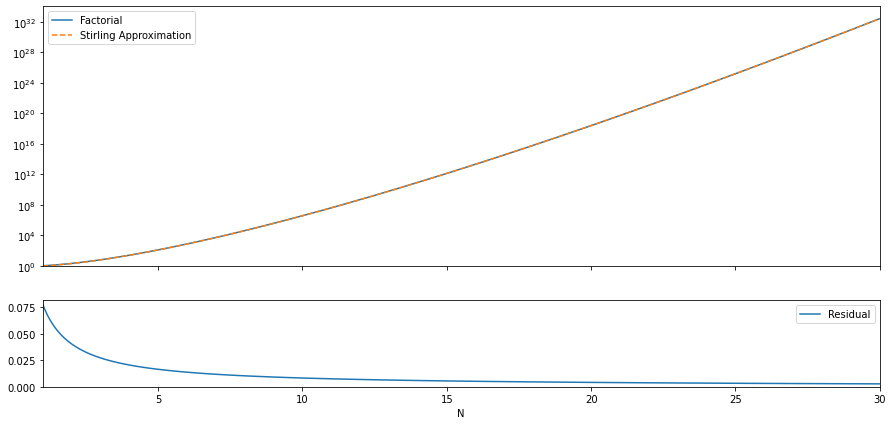

In [102]:
from scipy.special import factorial

def stirling(N):
  return N**N * np.exp(-N) * np.sqrt(2*np.pi*N)

N_stirling = np.geomspace(1, 30, num=100)

fig, axs = plt.subplots(figsize=(15, 7), nrows=2, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
fac = factorial(N_stirling, exact=False)
approx = stirling(N_stirling)
axs[0].plot(N_stirling, fac, label="Factorial")
axs[0].plot(N_stirling, approx, label="Stirling Approximation", ls="--")
axs[0].legend()
axs[0].set_yscale("log")
axs[0].set_ylim(1)
res = (fac - approx) / fac
axs[1].plot(N_stirling, res, label="Residual")
axs[1].set_ylim(0)
axs[1].legend()
axs[1].set_xlabel("N")
plt.setp(axs, xlim=(1, N_stirling.max()))
plt.show()

You should find that residual $\rightarrow 0$ as $N \rightarrow \infty$.

Next, consider the Poisson distribution (Kardar p. 42):
$$ P(\lambda) = \frac{\lambda^k e^{-\lambda}}{k!} $$
where $k$ is the number of occurrences. Its mean and variance are $\lambda$.<br><br>
<span style="color:blue"> <i> 3. Plot $P(\lambda)$ as a function of $k$ for $\lambda = 1, 3, 5, 10, 20$. In the same figure, plot the Gaussian with mean and variance for the Poisson and see how similar they get. Make sure to label. </i></span><br>

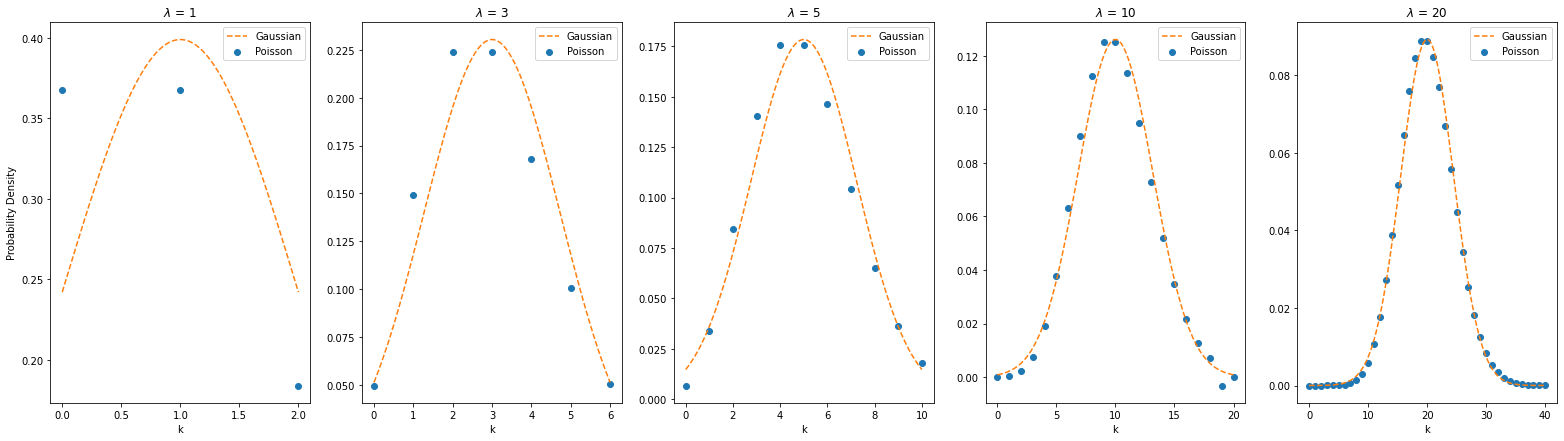

In [129]:
"""
We note that the mean and variance of the Poissonian is Lambda
"""


def poisson(k, lam):
  return lam**k * np.exp(-lam) / factorial(k, exact=True)

lambda_vals = [1, 3, 5, 10, 20]

fig, axs = plt.subplots(figsize=(27, 7), ncols=len(lambda_vals))
for i, L in enumerate(lambda_vals):
  plt.sca(axs.ravel()[i])
  k = np.arange(2*L+1)
  p = poisson(k, L)
  if L == 20:  # there is some weird bug that makes the poisson be negative and 0 for large k in this case when computed on a numpy array so we do it in a loop
    pvals = []
    for i in range(k.size):
      pvals.append(poisson(i, 20))
    p = pvals
  plt.scatter(k, p, label="Poisson", color="C0")
  mean = L
  variance = L
  smooth_k = np.linspace(0, 2*mean, 100)
  g = gauss(smooth_k, mean, variance)
  plt.plot(smooth_k, g, label="Gaussian", color="C1", ls="--")
  plt.legend()
  plt.xlabel("k")
  if i == 0:
    plt.ylabel("Probability Density")
  plt.title("$\\lambda$ = {}".format(L))
plt.show()

<span style="color:blue"> <i> 4. What happens as the mean/$N$ increases? </i></span><br>

<span style="color:blue"><i> Answer: </i></span><br>
As expected, both the Binomial and Poisson distributions approach the Gaussian distribution as mean/N increases. This demonstrates the central limit theorem.

***

#### Problem 3 - Fitting Data to a Straight Line (Linear Regression)

(Reference - NR 15.2) We fit a set of 50 data points $(x_i, y_i)$ to a straight-line model $y(x) = a + bx$. The uncertainty $\sigma_i$ associated with each measurement $y_i$ is known, and we assume that the $x_i$'s are known exactly. To measure how well the model agrees with the data, we use the chi-square merti function: <br>
$$ \chi^2(a,b) = \sum_{i=0}^{N-1} \big( \frac{y_i-a-bx_i}{\sigma_i} \big)^2. $$
<br>
Make a scatter plot of data (including uncertainties) and find the best-fit line. Compute the errors on the two parameters $a$ and $b$ and plot lines where the two are changed by $\pm 1\sigma$.

<br>
<span style="color:blue"> <i> 1. Plot data (make sure to include error bars). (Hint - https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.errorbar.html) </i></span><br>


<span style="color:red"> NOTE: In this and all future assignments, you are expected to show error bars in all figures if the data include uncertainties. </span>

In [130]:
# Load a given 2D data
data = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW2/Problem3_data.dat")
x = data[:,0]
y = data[:,1]
sig_y = data[:,2]

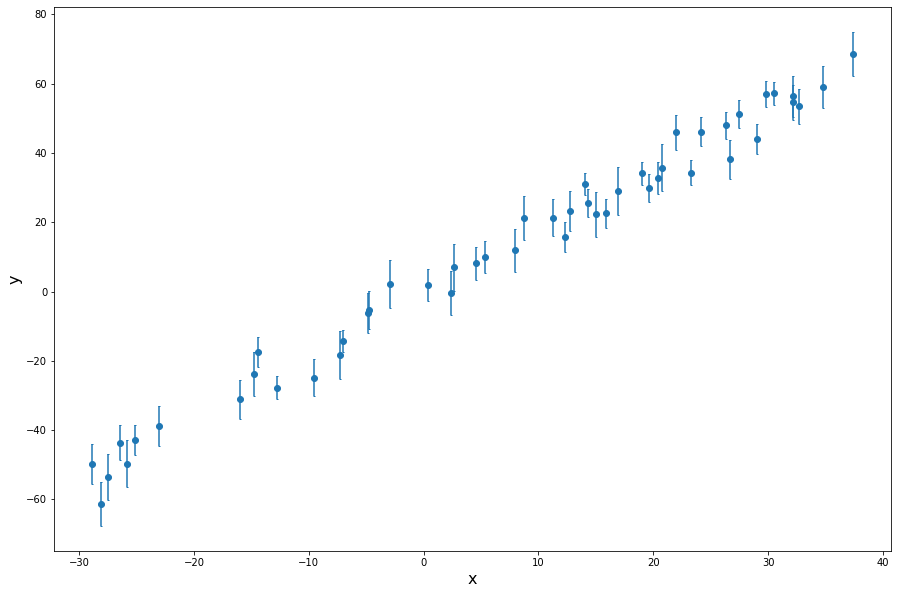

In [131]:
plt.figure(figsize=(15, 10))
plt.errorbar(x, y, yerr=sig_y, fmt="o", capsize=1)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

(NR p. 781) We should minimize the above chi-square function to determine $a$ and $b$. At its minimum, derivatives of $\chi^2$ with respect to $a, b$ vanish:
$$ \frac{\partial{\chi^2}}{\partial{a}} = -2 \sum \frac{y_i - a - bx_i}{\sigma_i^2} = 0 \ \ \ \ \ \ \ \ \ \ \ \ (1) $$
$$ \frac{\partial{\chi^2}}{\partial{b}} = -2 \sum \frac{x_i(y_i - a - bx_i)}{\sigma_i^2} = 0   \ \ \ \ \ \ \ \ \ (2) $$
<br>
These conditions can be rewritten in a convenient form if we define the following sums:
$$ S = \sum \frac{1}{\sigma_i^2},\ S_x = \sum \frac{x_i}{\sigma_i^2},\ S_y = \sum \frac{y_i}
{\sigma_i^2} $$
$$ S_{xx} = \sum \frac{x_i^2}{\sigma_i^2},\ S_{xy} = \sum \frac{x_iy_i}{\sigma_i^2} $$
<br> With these, we can rewrite (1), (2) as:
$$ a*S + b*S_x = S_y $$
$$ a*S_x + b*S_{xx} = S_{xy} $$
<br> The solution to these is calculated as:
$$ \Delta = SS_{xx} - (S_x)^2 $$ <br>
$$ a = \frac{S_{xx}S_y - S_xS_{xy}}{\Delta} $$
$$ b = \frac{SS_{xy} - S_xS_y}{\Delta} $$
<br><span style="color:blue"><i> 2. Find parameters $a, b$ which minimize the chi-square function and plot the best-fit line on top of the data. </i></span><br>

The best-fit parameters are:
a = -0.5952309466393884, b = 1.7746965875529703


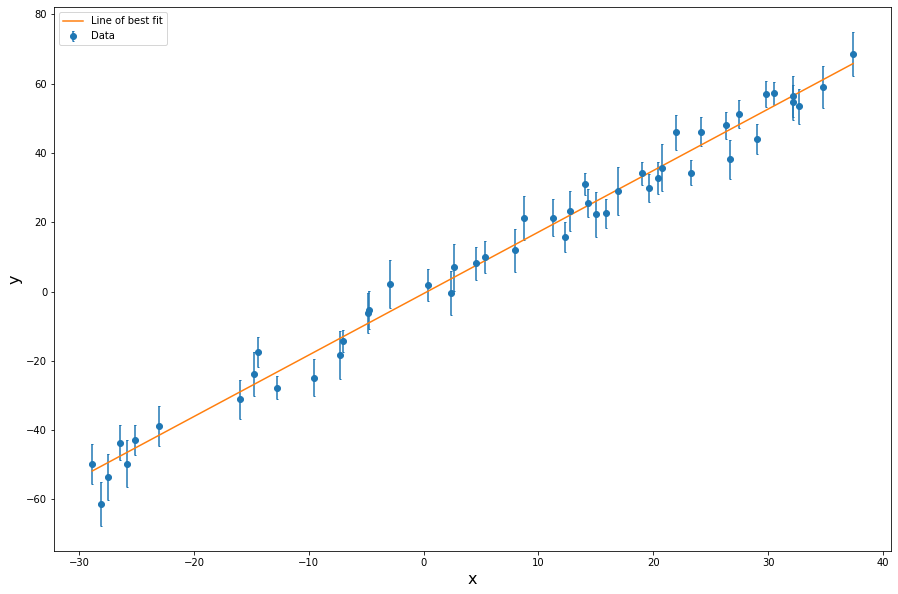

In [132]:
S = np.sum(1/sig_y**2)

Sx = np.sum(x/sig_y**2)
Sy = np.sum(y/sig_y**2)

Sxx = np.sum(x**2 / sig_y**2)
Sxy = np.sum(x*y / sig_y**2)

Delta = S * Sxx - Sx**2

a = (Sxx * Sy - Sx * Sxy) / Delta
b = (S * Sxy - Sx * Sy) / Delta

print("The best-fit parameters are:")
print(f"a = {a}, b = {b}")

xgrid = np.linspace(x.min(), x.max(), 200)

def line(x, a, b):
  return a + b * x

plt.figure(figsize=(15, 10))
plt.errorbar(x, y, yerr=sig_y, fmt="o", capsize=1, label="Data")
plt.plot(xgrid, line(xgrid, a, b), label="Line of best fit")
plt.legend()
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

Now, we must estimate the probable uncertainties in the estimates of $a$ and $b$, since obviously the measurement errors in the data must introduce some uncertainty in the determination of those parameters. If the data are independent, then each contributes its own bit of uncertainty to the parameters. Consideration of propagation of errors show that the variance $\sigma_f^2$ in the value of any function will be 
$$ \sigma_f^2 = \sum \sigma_i^2 (\frac{\partial f}{\partial y_i})^2 $$
<br> For the straight line, the derivatives of $a$ and $b$ with respect to $y_i$ can be directly evaluated from the solution:
$$ \frac{\partial a}{\partial y_i} = \frac{S_{xx}-S_x x_i}{\sigma_i^2 \Delta} $$
$$ \frac{\partial b}{\partial y_i} = \frac{S x_i-S_x}{\sigma_i^2 \Delta} $$
<br> Summing over the points, we get
$$ \sigma_a^2 = S_{xx}/\Delta $$
$$ \sigma_b^2 = S/\Delta $$

<span style="color:blue"> <i> 3. Compute the errors ($\sigma_a, \sigma_b$) on the two parameters $a, b$ and plot lines where the two are changed by $\pm 1\sigma$.</i></span><br>
(Hint - Try to plot the 1$\sigma$ confidence band as in http://astropython.blogspot.com/2011/12/. You can use plt.fill_between to shade the region between plots.)

The errors on the best-fit parameters are:
Error on a = 0.8, Error on b = 0.04


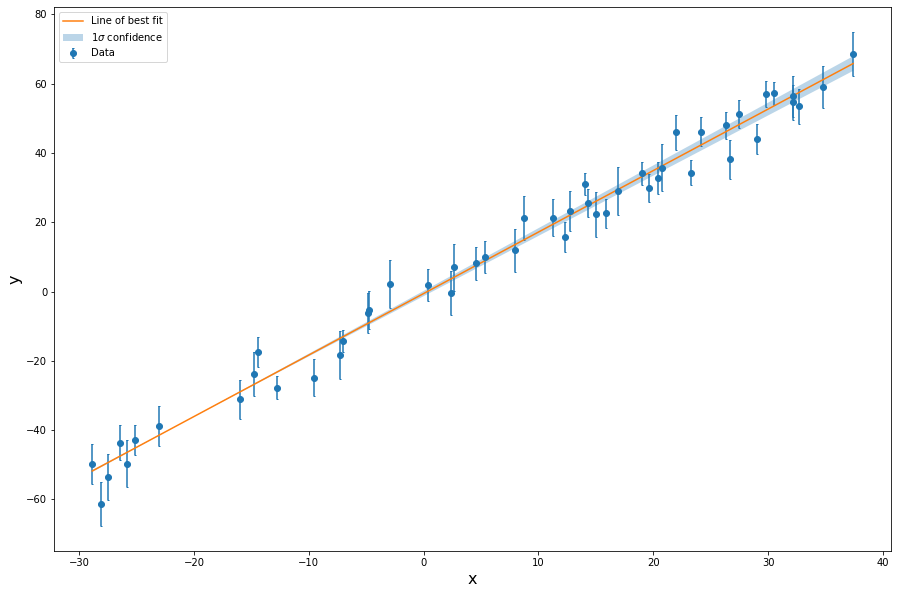

In [144]:
sig_a = np.sqrt(Sxx / Delta)
sig_b = np.sqrt(S / Delta)

print("The errors on the best-fit parameters are:")
print(f"Error on a = {sig_a:.1g}, Error on b = {sig_b:.1g}")


plt.figure(figsize=(15, 10))
plt.errorbar(x, y, yerr=sig_y, fmt="o", capsize=1, label="Data")
plt.plot(xgrid, line(xgrid, a, b), label="Line of best fit")
# plt.plot(xgrid, line(xgrid, a + sig_a, b + sig_b), label="$+1\\sigma$")
# plt.plot(xgrid, line(xgrid, a - sig_a, b - sig_b), label="$-1\\sigma$")
plt.fill_between(xgrid, line(xgrid, a - sig_a, b - sig_b), line(xgrid, a + sig_a, b + sig_b), alpha=.3, label="$1\\sigma$ confidence")
plt.legend()
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

***

#### Problem 4 - Introduction to Supervised Learning

This problem will serve as an introduction to machine learning, and it will use 1-D data fitting as an example. The power of machine learning is far greater than demonstrated in this problem, but for this example, no special machine learning packages will be required, and you will write all of the required code.

The general goal of a supervised learning problem is to develop a model that can predict a label $y \in \mathcal{Y}$ from an input $x \in \mathcal{X}$ using existing sets of data $\{x_i, y_i\}_{i=1,...,n}$. When $\mathcal{Y}$ is discrete, this is called a classification problem, and when $\mathcal{Y}$ is continuous, this is called a regression problem.

We will use the very simple example of one-dimensional, real input and output, equivalently: $\mathcal{X}=\mathcal{Y}=\mathbb{R}$.

The model that is developed is called a *neural network*. The neural network is in general a flexible function $f_\phi: \mathcal{X} \rightarrow \mathcal{Y}$ which has internal parameters $\phi$. These parameters $\phi$ are *trained* in order to best predict the labels $y$ from the input $x$. In general, this network can be extremely complicated, especially when the input data is high-dimensional and/or has meaningful structure, but for this case, our neural network will just be a polynomial function of order $m$, and the model parameters $\phi$ are the coefficients:

$$f_\phi(x) = \phi_0 + \phi_1 x + \phi_2 x^2 + ... + \phi_m x^m.$$

<span style="color:blue"> <i> 4a. Write this general neural network function that takes in vectors $\phi$ and $x$. Make sure that this can be evaluated on a vector of x values, giving a vector of the same size. </i></span><br>


In [145]:
def f(phi, x):
  phi = np.array(phi)
  x = np.array(x)
  if len(x) > 1:  # x is a vector
    phi = phi.reshape(-1, 1)
    x = x.reshape(1, -1) 
  m = len(phi) - 1
  return np.sum(phi * x ** np.arange(m + 1).reshape(-1, 1), axis=0)

The goal of the training procedure for this neural network is made concrete via a *loss function* $\mathcal{L}(f_\phi(x), y)$. This function is a measure of how poorly the neural network predicts the output labels. In many cases, like this one, the *squared error* is used as a loss function:

$$\mathcal{L}(f_\phi(x), y)=(y-f_\phi(x))^2.$$

The goal of the training procedure is to minimize the expectation value of this loss function over the distribution from which the input data is drawn. We call this expectation value of the loss function the *risk*. The risk represents how bad you expect your model to be at predicting new data, so it is precisely what we want to minimize. For supervised learning, we have a sample of this data with labels of size $n$: $\{x_i, y_i\}_{i=1,...,n}$. We can approximate the risk as the average loss over our sample, which we call the *empirical risk*:

$$R_{emp}=\frac{1}{n}\sum\limits_{i=1}^{n}\mathcal{L}(f_\phi(x_i), y_i).$$

<span style="color:blue"> <i> 4b. Load the data (given) and write functions that compute the loss and the empirical risk from parameters $\phi$ and data $x$ with labels $y$. Be sure to allow vector input for $x$ and $y$.  </i></span><br>

In [146]:
data = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW2/Problem4_data.dat")
x = data[0,:]
y = data[1,:]

In [147]:
def loss(phi, x, y):
  return (y - f(phi, x))**2

def risk(phi, x, y):
  n = len(x)
  l = loss(phi, x, y)
  return l.sum() / n

There are many minimization algorithms that can be used to minimize the risk, and we will see others later in this course, but one of the simplest and most well-known minimization algorithms is called gradient descent.

The gradient shows the direction of steepest increase in a function. The opposite direction is the direction of steepest decrease. Gradient descent simply starts at a random point and moves in the opposite direction of the gradient for a large number of iterations. In many situations, this will find the minimum.

In order to do this, we must first write a function to compute the gradient. We can accurately evaluate each component of the gradient using finite differencing:

$$\vec\nabla f = \sum_i \frac{df}{d\phi_i} \hat{\phi_i}$$

$$\frac{df}{d\phi_i}\approx\frac{f(\vec \phi + \delta \cdot \hat{\phi_i})-f(\vec \phi)}{\delta},$$

where $\hat{\phi_i}$ is the $i$th unit vector and $\delta$ is a very small number, we can use $\delta=10^{-4}$.

Now the gradient descent algorithm will begin with an initial set of parameters $\phi^0$ (not to be confused with the first element of $\phi$, $\phi_0$) and subtract a multiple of the gradient to reach the next step:

$$\phi^{i+1}=\phi^i-\lambda\nabla\phi^i$$

$\lambda$ is called the learning rate, and I suggest to use $\lambda=0.5$. This process should iterate for some number of steps, say 1000.

<span style="color:blue"> <i> 4c. Write a function that computes a finite differenced gradient given that function $f$, initial input $\phi^0$, and stepsize $\delta$. Then write a function that runs gradient descent and outputs the set of parameters found for each iteration. Make sure it supports a general function $f$ to minimize, initial parameters $\phi^0$, learning rate $\lambda$, finite differencing stepsize $\delta$, and a number of iterations. </i></span><br>

In [148]:
def grad(f, phi, step):
  N = len(phi)
  grad_f = np.empty(N)
  for i in range(N):
    # phi_i, the ith unit vector
    unit_vec = np.zeros(N)
    unit_vec[i] = 1

    grad_f[i] = (f(phi + step * unit_vec) - f(phi)) / step
  
  return grad_f

def grad_descent(f, phi0, step, learning_rate, N_iterations):
  N = len(phi0)
  all_phis = np.empty((N_iterations, N))
  all_phis[0] = phi0
  for i in range(N_iterations-1):  # we know the 0th point so only need N-1 loops
    phi = all_phis[i]
    g = grad(f, phi, step)  # compute gradient
    all_phis[i+1] = phi - learning_rate * g  # update phi
  return all_phis

<span style="color:blue"> <i> 4d. Now we want to fit our data to a linear function. Run your gradient descent function (with $\phi^0=[0,0]$, $\lambda=0.5$, $\delta=10^{-4}$, and 1000 iterations) on the risk and plot the two parameters in a connected scatter plot that shows the progression of the gradient descent algorithm toward the best fit parameters. Plot the first and last point in separate colors. </i></span><br>
(Hint: you might want to use an anonymous/lambda function as the input to your gradient descent function so that you can specify the data $x$ and labels $y$ in the risk.)

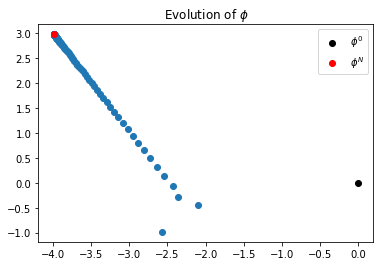

In [149]:
params = grad_descent(lambda phi: risk(phi, x, y), [0, 0], 1e-4, 0.5, 1000)

plt.figure()
plt.scatter(*params[0], c="k", label="$\\phi^0$")
plt.scatter(*params[1:-1].T)
plt.scatter(*params[-1], c="red", label="$\\phi^N$")
plt.legend()
plt.title("Evolution of $\\phi$")
plt.show()

<span style="color:blue"> <i> 4d. Now make a scatter plot of the data and draw the best fit line found by the last iteration of gradient descent. The input data $x$ is entirely within the interval $[0,1]$.</i></span><br>

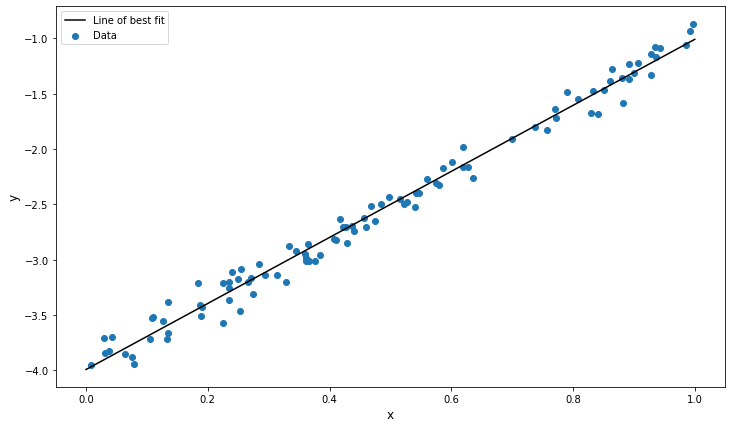

In [150]:
plt.figure(figsize=(12, 7))
plt.scatter(x, y, label="Data")
xgrid = np.linspace(0, 1, 200)
plt.plot(xgrid, f(params[-1], xgrid), label="Line of best fit", c="k")
plt.legend()
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.show()

Now let's try doing this again with a new dataset that has more complexity, but still with input $x \in [0,1]$. This time, we'll try increasing the number of parameters.

<span style="color:blue"> <i> 4e. Load the new data (given) and train neural networks for polynomials of order 1, 2, 3, and 4 ($m = 2,3,4,$ and $5$ terms, don't forget the constant term!). Increase the number of iterations to 10000 (this will take a few seconds to run but it helps to train the more complicated networks). Then plot the training data and the polynomials of these orders. Finally, compute and print the empirical risk for each model on the training data. </i></span><br>

In [151]:
# Load the data
data = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW2/Problem4_data.dat")
x2 = data[2,:]
y2 = data[3,:]

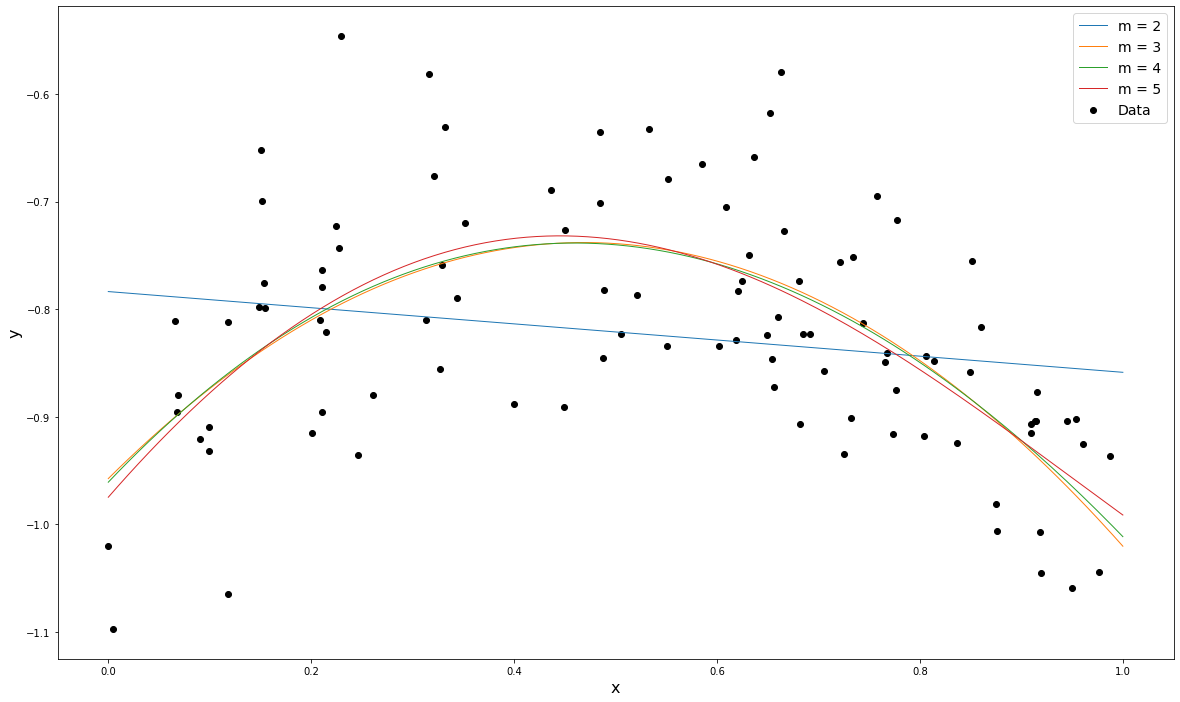

In [152]:
m_vals = [2, 3, 4, 5]
risks = np.empty(len(m_vals))

best_params = []

plt.figure(figsize=(20, 12))
plt.scatter(x2, y2, label="Data", c="k")

for i, m in enumerate(m_vals):
  phi0 = np.zeros(m)
  params = grad_descent(lambda phi: risk(phi, x2, y2), phi0, 1e-4, 0.5, 10000)
  risks[i] = risk(params[-1], x2, y2)
  plt.plot(xgrid, f(params[-1], xgrid), label=f"m = {m}", lw=1)
  best_params.append(params[-1])

plt.legend(fontsize=14)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

In [153]:
print("Empirical risk:")
for i, m in enumerate(m_vals):
  print(f"m = {m}, Risk = {risks[i]:.3e}")

Empirical risk:
m = 2, Risk = 1.230e-02
m = 3, Risk = 7.499e-03
m = 4, Risk = 7.456e-03
m = 5, Risk = 7.419e-03


If you have too few parameters in your network, you may not be able to correctly capture the complexity and diversity of the data, and this will lead to inaccurate predictions. But too many parameters can also be problematic. In many cases, the actual data that you might want to predict with your neural network might have a broader scope than the training data. Because of this, you want to be sure not to overfit your data with a model with too many parameters. If you have too many parameters, you will fit more than the underlying signal; you will also fit the noise. This will lead to a poor fit to testing data.

Here you are given an expanded set of testing data, which is in the expanded interval $[0, 2]$.

<span style="color:blue"> <i> 4e. Load the new testing data (given) and plot it with the trained polynomials from the previous part in the expanded interval. Then compute and print the empirical risk for each model on the testing data. </i></span><br>

In [154]:
# Load the data
data = np.loadtxt("/content/drive/My Drive/P188_288/P188_288_HW2/Problem4_data.dat")
x3 = data[4,:]
y3 = data[5,:]

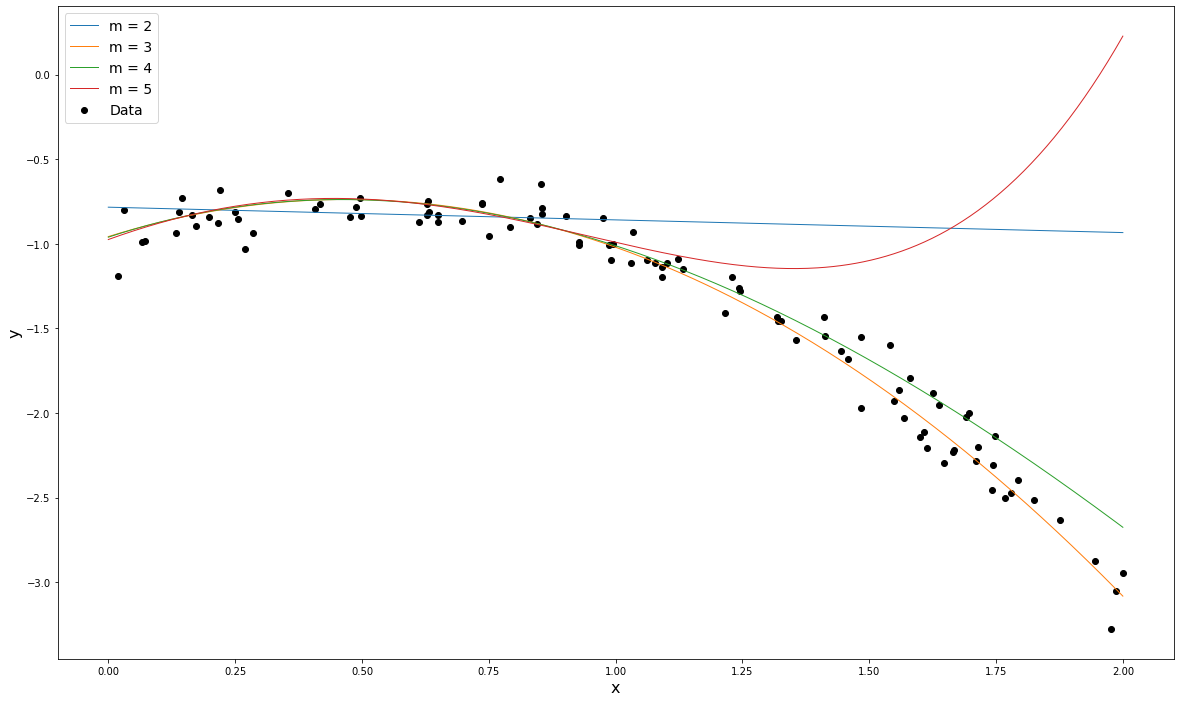

In [155]:
plt.figure(figsize=(20, 12))
plt.scatter(x3, y3, label="Data", c="k")

xgrid2 = np.linspace(0, 2, num=400)
risk_test = np.empty(len(m_vals))

for i, m in enumerate(m_vals):
  risk_test[i] = risk(best_params[i], x3, y3)
  plt.plot(xgrid2, f(best_params[i], xgrid2), label=f"m = {m}", lw=1)

plt.legend(fontsize=14)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.show()

In [156]:
print("Empirical risk (test set):")
for i, m in enumerate(m_vals):
  print(f"m = {m}, Risk = {risk_test[i]:.3e}")

Empirical risk (test set):
m = 2, Risk = 6.568e-01
m = 3, Risk = 1.270e-02
m = 4, Risk = 2.548e-02
m = 5, Risk = 9.076e-01


<span style="color:blue"> <i> 4f. Which neural network best predicts the labels for the testing data? </i></span><br>

<span style="color:blue"> <i> Answer: </i></span><br> The second order polynomial (m = 3) predicts the labels best for the testing data. We see this both visually (the orange curve clearly follows the data best) and quantitatively (this has the smallest risk).

***

#### Problem 5 - Unsupervised Learning: UMAP + clustering

Yann LeCun and collaborators collected and processed  70,000  handwritten digits to produce what became known as the most widely used database in ML, called MNIST. In this assignment, we are going to work with this dataset. Each handwritten digit comes in a square image, divided into a  28×28  pixel grid. Every pixel can take on  256  nuances of the gray color, interpolating between white and black, and hence each the data point assumes any value in the set  {0,1,…,255}. There are  10  categories in the problem, corresponding to the ten digits.

Ever since, the MNIST problem has become an important standard for benchmarking the performance of more sophisticated Machine Learning models. Often times, there are contests for finding a new constellation of hyperparameters and/or model architecture which results in a better accuracy for correctly classifying the digits.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
Y = mnist.target

X = X.to_numpy()
Y = Y.to_numpy()

"$X$" contains information about the given MNIST digits. We have a 28x28 pixel grid, so each image is a vector of length 784; we have 70,000 images (digits), so $X$ is a 70,000x784 matrix. "$Y$" is a label (0-9; the category to which each image belongs) vector of length 70,000.

<span style="color:blue"> <i> 5a. Do the following:

(1) Randomly shuffle data (i.e. randomize the order)

  (Note: The label $Y_1$ corresponds to a vector $X_{1j}$, and even after shuffling, $Y_1$ should still correspond to $X_{1j}$.)
  
  
(2) Select 1/3 of the data. (You are free to work with a larger set of the data, but it will take much longer time to train.)


(3) Split data into training and test samples using train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Set train_size = 0.8. (80% of $X$ is our training samples.) Print the dimension of training and test samples. </i></span> <br>

In [2]:
print(X.shape, Y.shape)

(70000, 784) (70000,)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# we shuffle and select 1/3 of the data with the train test split function
X, _, Y, _ = train_test_split(X, Y, train_size=1/3, random_state=42)  # discard the other 2/3

# now we do the actual train and test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

print("Dimensions of training set")
print(f"X: {X_train.shape}")
print(f"Y: {Y_train.shape}")
print("\nDimensions of test set")
print(f"X: {X_test.shape}")
print(f"Y: {Y_test.shape}")

Dimensions of training set
X: (18666, 784)
Y: (18666,)

Dimensions of test set
X: (4667, 784)
Y: (4667,)


<span style="color:blue"> <i> 5b. Choose any five images and show what they look like. Also, print the corresponding label to each image. </i></span> <br>

Hint: each image is a vector of length 784. So reshape it into a 28x28 matrix.

&nbsp; **X_0 = X_train[0]** <br>
&nbsp; **X_0 = X_0.reshape((28, 28))**
  
Then, make a plot using imshow

&nbsp; **plt.imshow(X_0, cmap=plt.cm.gray)**

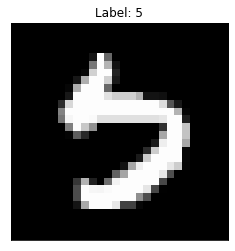

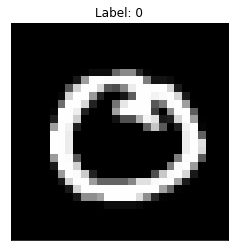

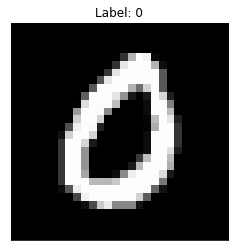

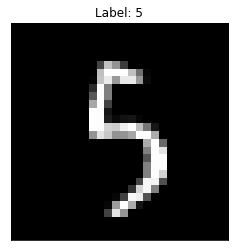

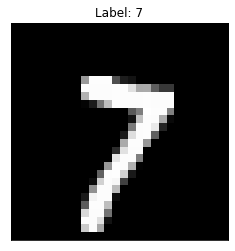

In [7]:
for i in range(5):
  plt.figure()
  plt.imshow(X_train[i].reshape((28, 28)), cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title(f"Label: {Y_train[i]}")

The following exercises are taken from the tutorial here: https://umap-learn.readthedocs.io/en/latest/index.html. Please go through them if you want to learn more about the umap package.

**UMAP** (Uniform Manifold Approximation and Projection for Dimension Reduction) is a general purpose manifold learning and dimension reduction algorithm. It is designed to be compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. If you are already familiar with sklearn you should be able to use UMAP as a drop in replacement for t-SNE and other dimension reduction classes.

In [8]:
!pip install umap-learn
import umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 27.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=074b054675136f3585b5f9c78380cbf13e6399fc422cdbcbcd84cf4801d75e21
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=b7cbe6bf93fe2ac96e8fc88f068846c368f3b2c0537c9fd20107f0bcfce2617a
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


While UMAP can be used for standard unsupervised dimension reduction the algorithm offers significant flexibility allowing it to be extended to perform other tasks, including making use of categorical label information to do supervised dimension reduction, and even metric learning.

Let's use labels ("$Y$") to do supervised learning.

How do we go about coercing UMAP to make use of target labels? If you are familiar with the sklearn API you’ll know that the fit() method (here, you can think of "fitting" as "training.") takes a target parameter y that specifies supervised target information (for example when training a supervised classification model). We can simply pass the UMAP model that target data when fitting and it will make use of it to perform supervised dimension reduction!

First, define your UMAP model:

&nbsp; **model = umap.UMAP()**

Then, using "fit_transform," fit your training sample into an embedded space, with the target array ("Y") for supervised dimension reduction specified.

&nbsp; **embedding_train = model.fit_transform(training X data, training Y label)**

You can use this trained model to transform new data - which is "test data" in this case.

&nbsp; **embedding_test = model.transform(test X data)**

By default, data has reduced down to 2 dimensions. (i.e. embedding_test will have dimensions = (# of test data, 2) - it is an array with test samples, but with 2 feature columns. Each row of the array is a 2-dimensional representation of the corresponding digit.) Thus we can plot the embedding as a standard scatterplot and color by the target array (since it applies to the transformed data which is in the same order as the original).

&nbsp; **plt.scatter(embedding[:, 0], embedding[:, 1], ...)**

<span style="color:blue"> <i> 5c. Do the supervised learning and create scatterplots for both training and test data. Color data points according to the corresponding target array $Y$. Make sure to label all 10 classes. Are they cleanly separated?</i></span> <br>


In [9]:
model = umap.UMAP()
embedding_train = model.fit_transform(X_train, Y_train)
embedding_test = model.fit_transform(X_test, Y_test)

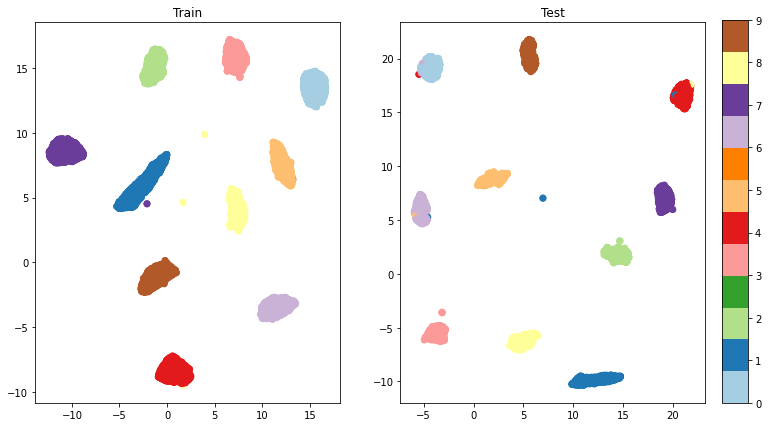

In [10]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

norm = Normalize(vmin=0, vmax=9)
sm = ScalarMappable(norm=norm, cmap="Paired")

fig, axs = plt.subplots(figsize=(12, 7), ncols=2)
axs[0].scatter(embedding_train[:, 0], embedding_train[:, 1], c=Y_train.astype(int), cmap="Paired")
axs[0].set_title("Train")
axs[1].scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_test.astype(int), cmap="Paired")
axs[1].set_title("Test")
cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

The data points are clearly separated for the training set (with 3 outliers, one from class 7 (purple) and 2 from class 8 (yellow) that are away from their clusters). In the test set, the images are largely separated but there are some points in the wrong classes.

UMAP has several hyperparameters that can have a significant impact on the resulting embedding: n_neighbors, min_dist, n_components, and metric. (https://umap-learn.readthedocs.io/en/latest/parameters.html)

Each of these parameters has a distinct effect, and we will look at n_neighbors and n_components.

**n_neighbors** controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data.

We can see that in practice by fitting our dataset with UMAP using a range of n_neighbors values. The default value of n_neighbors for UMAP (as used above) is 15.

<span style="color:blue"> <i> 5d. Choose n_neighbors=2 and n_neighbors=200. What happens as we increase n_neighbors? </i></span> <br>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/s

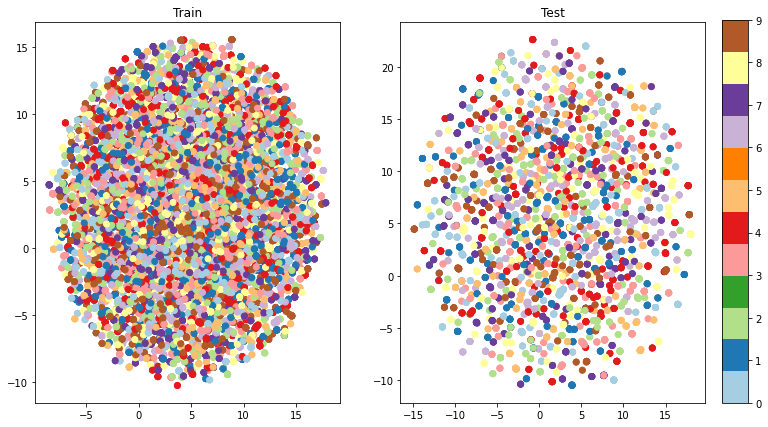

In [11]:
# 2 neighbors

model = umap.UMAP(n_neighbors=2)
embedding_train = model.fit_transform(X_train, Y_train)
embedding_test = model.fit_transform(X_test, Y_test)

fig, axs = plt.subplots(figsize=(12, 7), ncols=2)
axs[0].scatter(embedding_train[:, 0], embedding_train[:, 1], c=Y_train.astype(int), cmap="Paired")
axs[0].set_title("Train")
axs[1].scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_test.astype(int), cmap="Paired")
axs[1].set_title("Test")
cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

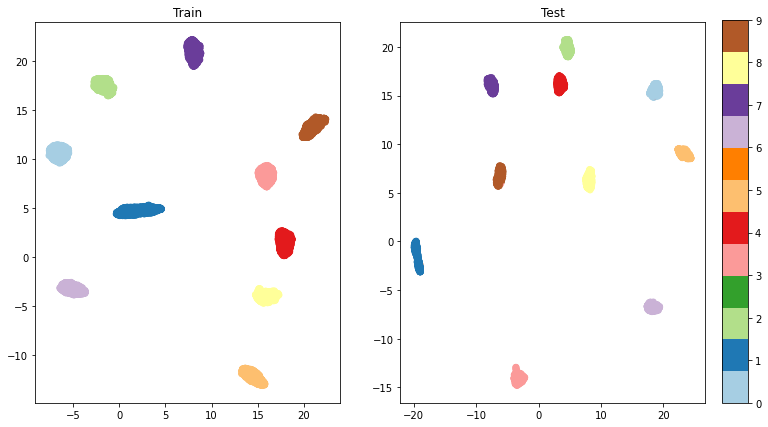

In [12]:
# 200 neighbors

model = umap.UMAP(n_neighbors=200)
embedding_train = model.fit_transform(X_train, Y_train)
embedding_test = model.fit_transform(X_test, Y_test)

fig, axs = plt.subplots(figsize=(12, 7), ncols=2)
axs[0].scatter(embedding_train[:, 0], embedding_train[:, 1], c=Y_train.astype(int), cmap="Paired")
axs[0].set_title("Train")
axs[1].scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_test.astype(int), cmap="Paired")
axs[1].set_title("Test")
cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

With a value of n_neighbors=2 we see that UMAP merely glues together small chains, but due to the narrow/local view, fails to see how those connect together. It also leaves many different components (and even singleton points). This represents the fact that from a fine detail point of view the data is very disconnected and scattered throughout the space.

As n_neighbors is increased UMAP manages to see more of the overall structure of the data, gluing more components together, and better coverying the broader structure of the data. By the stage of n_neighbors=20 we have a fairly good overall view of the data showing how the various colors interelate to each other over the whole dataset.

As n_neighbors increases further more and more focus in placed on the overall structure of the data. This results in, with n_neighbors=200 a plot where the overall structure is well captured, but at the loss of some of the finer local sturcture.

***

As is standard for many scikit-learn dimension reduction algorithms UMAP provides a **n_components** parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into. Unlike some other visualisation algorithms such as t-SNE UMAP scales well in embedding dimension, so you can use it for more than just visualisation in 2- or 3-dimensions.

For the purposes of this demonstration (so that we can see the effects of the parameter) we will only be looking at 1-dimensional and 3-dimensional embeddings, which we have some hope of visualizing.

First of all we will set n_components to 1, forcing UMAP to embed the data in a line. For visualisation purposes we will randomly distribute the data on the y-axis to provide some separation between points.

<span style="color:blue"> <i> 5e. Choose n_components=1 and n_components=3. Observe the scatterplots. </i></span> <br>

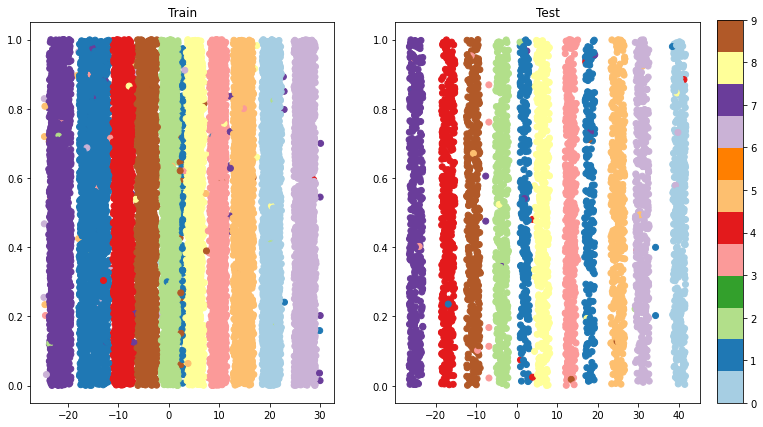

In [13]:
# n components = 1

model = umap.UMAP(n_components=1)
embedding_train = model.fit_transform(X_train, Y_train)
embedding_test = model.fit_transform(X_test, Y_test)

# distribute the points randomly on the y axis

yvals_train = np.random.uniform(size=embedding_train.size)
yvals_test = np.random.uniform(size=embedding_test.size)

fig, axs = plt.subplots(figsize=(12, 7), ncols=2)
axs[0].scatter(embedding_train[:, 0], yvals_train, c=Y_train.astype(int), cmap="Paired")
axs[0].set_title("Train")
axs[1].scatter(embedding_test[:, 0], yvals_test, c=Y_test.astype(int), cmap="Paired")
axs[1].set_title("Test")
cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

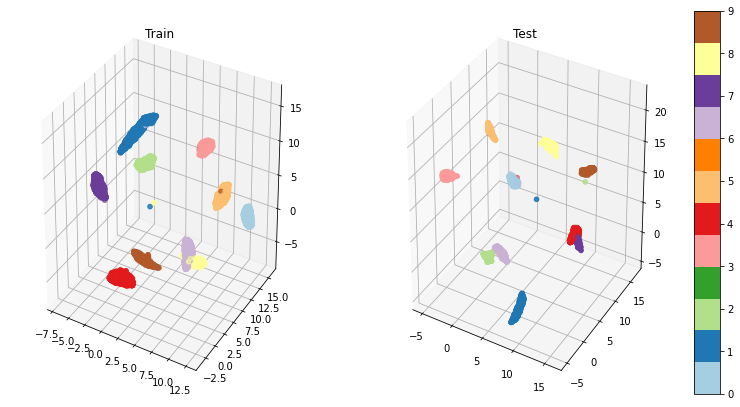

In [14]:
# n components = 3

model = umap.UMAP(n_components=3)
embedding_train = model.fit_transform(X_train, Y_train)
embedding_test = model.fit_transform(X_test, Y_test)

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(embedding_train[:, 0], embedding_train[:, 1], embedding_train[:, 2], c=Y_train.astype(int), cmap="Paired")
ax1.set_title("Train")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embedding_test[:, 0], embedding_test[:, 1], embedding_test[:, 2], c=Y_test.astype(int), cmap="Paired")
ax2.set_title("Test")

cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

UMAP is useful for generating visualisations, but if you want to make use of UMAP more generally for machine learning tasks it is important to be be able to train a model and then later pass new data to the model and have it transform that data into the learned space. For example if we use UMAP to learn a latent space and then train a classifier on data transformed into the latent space then the classifier is only useful for prediction if we can transform data for which we want a prediction into the latent space the classifier uses. Fortunately UMAP makes this possible, albeit more slowly than some other transformers that allow this.

To make use of UMAP as a data transformer we first need to fit the model with the training data. In this case we simply hand it the training data and it will learn an appropriate (two dimensional by default) embedding.

&nbsp; **model = umap.UMAP()**

&nbsp; **embedding_train_unsupervised = model.fit_transform(training X data)**

&nbsp; **embedding_test_unsupervised = model.transform(test X data)**

<span style="color:blue"> <i> 5f. Do the unsupervised learning and create scatterplots for both training and test data. Color data points according to the corresponding target array $Y$. Make sure to label all 10 classes. Compared to Part 3, how did they perform? Also, has the test data been embedded into 2 dimensions in exactly the locations we should expect (by class) given the embedding of the training data? </i></span> <br>

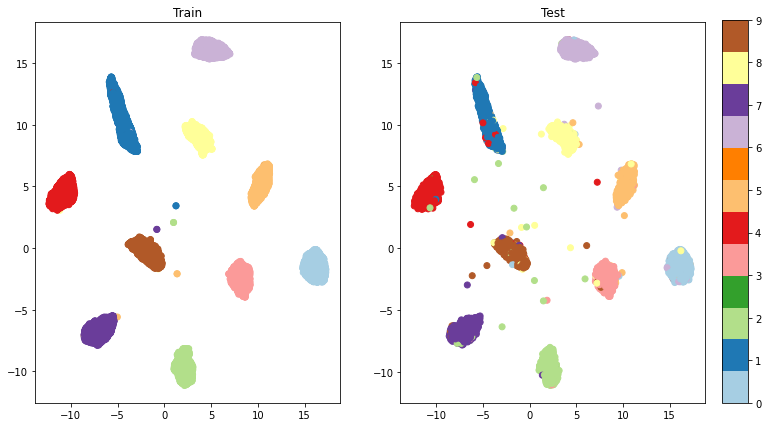

In [15]:
model = umap.UMAP()
embedding_train = model.fit_transform(X_train, Y_train)
embedding_test = model.transform(X_test)

fig, axs = plt.subplots(figsize=(12, 7), ncols=2)
axs[0].scatter(embedding_train[:, 0], embedding_train[:, 1], c=Y_train.astype(int), cmap="Paired")
axs[0].set_title("Train")
axs[1].scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_test.astype(int), cmap="Paired")
axs[1].set_title("Test")
cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

**ANSWER**
The Test set is obviously worse than in Part 3 since its transformed with the training data in this case. Compared to the trainig set, the test clusters are placed in similar spots and have almost the exact same shapes.

UMAP can be used as an effective preprocessing step to boost the performance of density based clustering. This is somewhat controversial, and should be attempted with care. For a good discussion of some of the issues involved in this please see the various answers in this stackoverflow thread (https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne) on clustering the results of t-SNE. Many of the points of concern raised there are salient for clustering the results of UMAP. The most notable is that UMAP, like t-SNE, does not completely preserve density. UMAP, like t-SNE, can also create tears in clusters that are not actually present, resulting in a finer clustering than is necessarily present in the data. Despite these concerns there are still valid reasons to use UMAP as a preprocessing step for clustering. As with any clustering approach one will want to do some exploration and evaluation of the clusters that come out to try to validate them if possible.

With all of that said, let’s work through an example to demonstrate the difficulties that can face clustering approaches and how UMAP can provide a powerful tool to help overcome them.

<span style="color:blue"> <i> 5g. Let's do unsupervised learning and identify distinct classes with the help of UMAP: </i></span> <br>

(1) First, reduce the data to 2-dimensions using UMAP. Do unsupervised learning on the training data. Choose "n_neighbors=30,min_dist=0.0,random_state=42"

For clustering, try HDBSCAN, which we believe to be among the most advanced density based tehcniques. 

(2) Create the HDBSCAN model (You can change the hyperparameter setting):

&nbsp; **HDBSCAN_model = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=100)**

(3) Take the embedding you created in (1) and get predicted classes using "fit_predict"

&nbsp; **HDBSCAN_labels = HDBSCAN_model.fit_predict(embedding)**

(4) Predicted label = -1 means that HDBSCAN refused to cluster that points and classify the as “noise.” Make the scatterplot in 2d using umap embedding and color points according to the cluster membership. Color noise as gray.

In [16]:
!pip install hdbscan
import hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2340281 sha256=b4f47c42da778e88779bc46e7b696337681169100e56d6dc06fcd3bfca5cd68f
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [18]:
model = umap.UMAP(n_neighbors=30, min_dist=0., random_state=42)
embedding = model.fit_transform(X_train, Y_train)

HDBSCAN_model = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100)
HDBSCAN_labels = HDBSCAN_model.fit_predict(embedding)

In [19]:
noise_idx = np.where(HDBSCAN_labels == -1)  # there is no noise
print(noise_idx)

(array([], dtype=int64),)


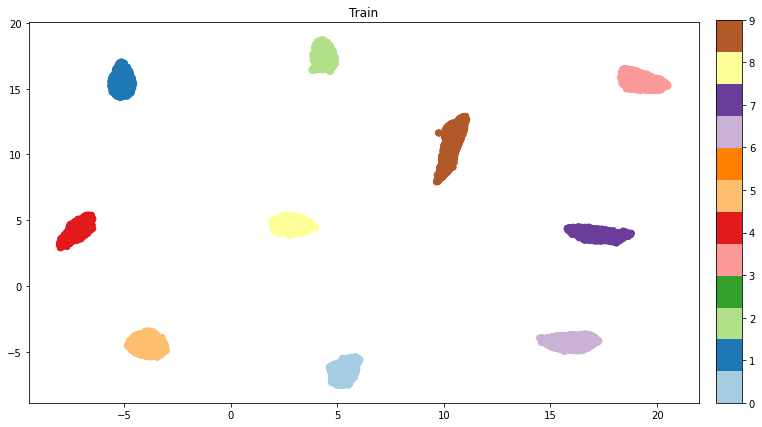

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(embedding[:, 0], embedding[:, 1], c=HDBSCAN_labels, cmap="Paired")
ax.set_title("Train")
cax = fig.add_axes([0.92, 0.125, 0.03, 0.76])
fig.colorbar(sm, cax=cax)
plt.show()

<span style="color:blue"> <i> 5h. Evaluate the adjusted Rand score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) and adjusted mutual information (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) for this clustering as compared with the true labels. </i></span> <br>

(Note: Changing the hyperparameters of UMAP/HDBSCAN model and increasing the total number of sample, you can improve those scores. You can check this if you have time.) 

In [23]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [29]:
ars = adjusted_rand_score(Y_train.astype(int), HDBSCAN_labels)
print(f"The adjusted rand score is {ars:.4g}.")

The adjusted rand score is 0.9969.


In [30]:
ami = adjusted_mutual_info_score(Y_train.astype(int), HDBSCAN_labels)
print(f"The adjusted mutual information is {ami:.4g}.")

The adjusted mutual information is 0.9954.


The fact that the scores are very close to 1 indicate very good agreement between the clusters of true labels and HBDSCAN labels.

***